In [1]:
#We need to install tf version 2.15 for compatibility with this notebook (written in March 2024).
!pip uninstall tensorflow
!pip install tensorflow==2.15.0
!tensorflow --version

Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Would remove:
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.17.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? y
  Successfully uninstalled tensorflow-2.17.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.9 MB/s eta 0:00:00
  Att

## Time series forecasting fundamentals with TensorFlow + Milestone Project 3: BitPredict 💰

Let's write some TensorFlow code to predict the price of Bitcoin based on the historical price of Bitcoin.

Links:
* All resources: https://github.com/mrdbourke/tensorflow-deep-learning/tree/main
* Book version of actual code/text: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/10_time_series_forecasting_in_tensorflow.ipynb



## Get data

We're going to be using the historical price data of Bitcoin to try to predict the future price of Bitcoin.
We downloaded the data from: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv



## Importing time series with Pandas

In [3]:
# Import with pandas
import pandas as pd
# Let's read in our Bitcoin data and parse the dates (Mark's data is newest to oldest so we must reverse it)
reversed_df = pd.read_csv("/content/bitcoin_historical_price.csv",
                 parse_dates=["End"],
                 index_col=["End"]) # parse the date column and tell pandas col1 is the date column

df = reversed_df.iloc[::-1] #now we reverse the order of rows of dataset so it is oldest to newest

#df.reset_index(drop=True, inplace=True) #now we reset the index values also from 0 to xx

df.head()

,Start,Open,High,Low,Close,Volume,Market Cap
End,,,,,,,
2015-03-20,2015-03-19,256.299,264.244,248.636,260.741,6.211636e+07,3.590838e+09
2015-03-21,2015-03-20,260.928,264.848,259.162,261.829,3.642180e+07,3.649281e+09
2015-03-22,2015-03-21,261.749,262.196,255.650,260.018,1.779879e+07,3.626065e+09
2015-03-23,2015-03-22,260.025,269.747,259.590,267.969,1.460092e+07,3.656061e+09
2015-03-24,2015-03-23,267.960,277.297,261.745,266.682,2.131579e+07,3.737938e+09


In [4]:
df.tail()

,Start,Open,High,Low,Close,Volume,Market Cap
End,,,,,,,
2024-03-14,2024-03-13,71421.13,73607.76,71333.36,73087.95,9.188318e+10,1.428493e+12
2024-03-15,2024-03-14,72961.03,73628.43,68699.98,71432.39,7.542228e+10,1.418447e+12
2024-03-16,2024-03-15,71536.18,72305.13,65867.11,69532.18,1.249379e+11,1.348026e+12
2024-03-17,2024-03-16,69561.38,69931.27,65249.77,65286.52,9.191429e+10,1.341113e+12
2024-03-18,2024-03-17,66031.71,68870.99,64949.86,68650.08,8.427848e+10,1.318368e+12


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3287 entries, 2015-03-20 to 2024-03-18
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Start       3287 non-null   object 
 1   Open        3287 non-null   float64
 2   High        3287 non-null   float64
 3   Low         3287 non-null   float64
 4   Close       3287 non-null   float64
 5   Volume      3287 non-null   float64
 6   Market Cap  3287 non-null   float64
dtypes: float64(6), object(1)
memory usage: 205.4+ KB


In [6]:
# How many samples do we have?
len(df)

3287

We've collected the historical price of bitcoin for the last 10 years but tehre are only 3287 sampels.  Typically deep learning models like lots and lots and lots of samples where lots and lots and lots can be thousands to tens of thousands to million or tens of millions.  

A smaller number of samples is something you'll often run into with time series data problems.  

> 🔑 the **seasonality** of a time series dataset refers to the number of samples per year.  So for our Bitcoin data, it has a seasonality of daily or value of 365 because we collect one sample per day meaning we will get 365 samples per year.  

In [7]:
# only want closing price for each day
#bitcoin_prices = df["Close"].rename(columns={"Close":"Price"})
bitcoin_prices = pd.DataFrame(df["Close"]).rename(columns={"Close":"Price"})

#rename index
bitcoin_prices.rename_axis("Date", inplace=True)

#bitcoin_prices = pd.DataFrame(bitcoin_prices["End"]).rename(columns={"End":"Date"})
bitcoin_prices.tail()

,Price
Date,
2024-03-14,73087.95
2024-03-15,71432.39
2024-03-16,69532.18
2024-03-17,65286.52
2024-03-18,68650.08


In [8]:

# Create a datetime object for September 1, 2021
from datetime import datetime

jasons_buy_date = datetime(2021, 9, 1)

jasons_buy_row = bitcoin_prices.loc[jasons_buy_date]

jasons_buy_row

,2021-09-01
Price,47225.2696


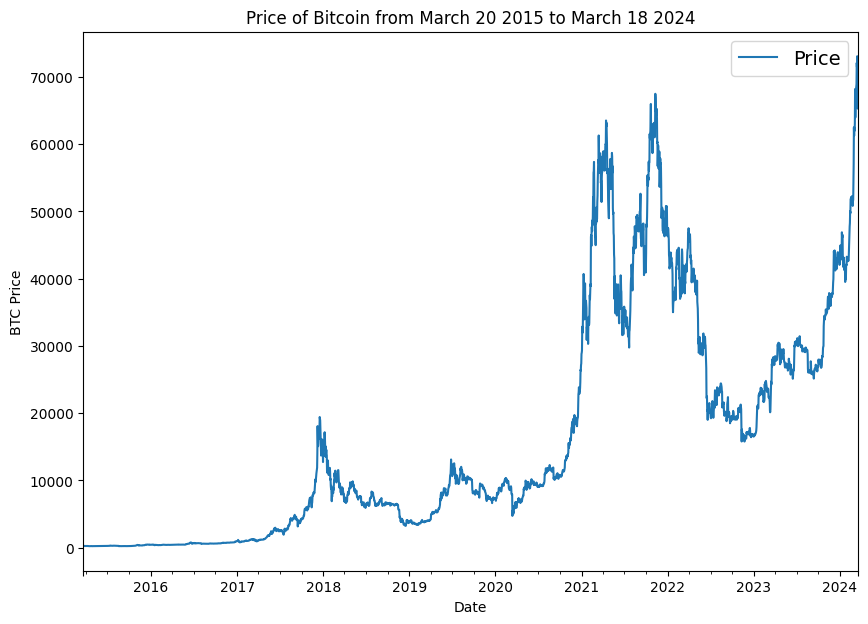

In [9]:
# Visualize the data
import matplotlib.pyplot as plt

bitcoin_prices.plot(figsize=(10,7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from March 20 2015 to March 18 2024")
plt.legend(fontsize=14)

In [10]:
# Challenge: Import the data with python csv
import csv
bitcoin_datafile_csv = []

with open('/content/bitcoin_historical_price.csv', newline="") as csvfile:
  bitcoin_python_csv = csv.reader(csvfile, delimiter=",", quotechar="|")
  for row in bitcoin_python_csv:
    bitcoin_datafile_csv.append(", ".join(row))



In [11]:
bitcoin_datafile_csv[1]

'2024-03-17, 2024-03-18, 66031.71, 68870.99, 64949.86, 68650.08, 84278484629.36586, 1318367503672.8572'

## Format Data Part 1: Create train and test sets of our time series data

### Creating training and test sets with time series data the wrong way

In [12]:
bitcoin_prices[:5]

,Price
Date,
2015-03-20,260.741
2015-03-21,261.829
2015-03-22,260.018
2015-03-23,267.969
2015-03-24,266.682


In [13]:
# Get bitcoin data ready
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2015-03-20T00:00:00.000000000', '2015-03-21T00:00:00.000000000',
        '2015-03-22T00:00:00.000000000', '2015-03-23T00:00:00.000000000',
        '2015-03-24T00:00:00.000000000', '2015-03-25T00:00:00.000000000',
        '2015-03-26T00:00:00.000000000', '2015-03-27T00:00:00.000000000',
        '2015-03-28T00:00:00.000000000', '2015-03-29T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([260.741, 261.829, 260.018, 267.969, 266.682, 245.055, 246.081,
        248.482, 247.066, 252.89 ]))

In [14]:
# Wrong way to make train/test sets for time series data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(timesteps,    # dates
                                                    prices,       # BTC prices
                                                    test_size=0.2,
                                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2629,), (658,), (2629,), (658,))

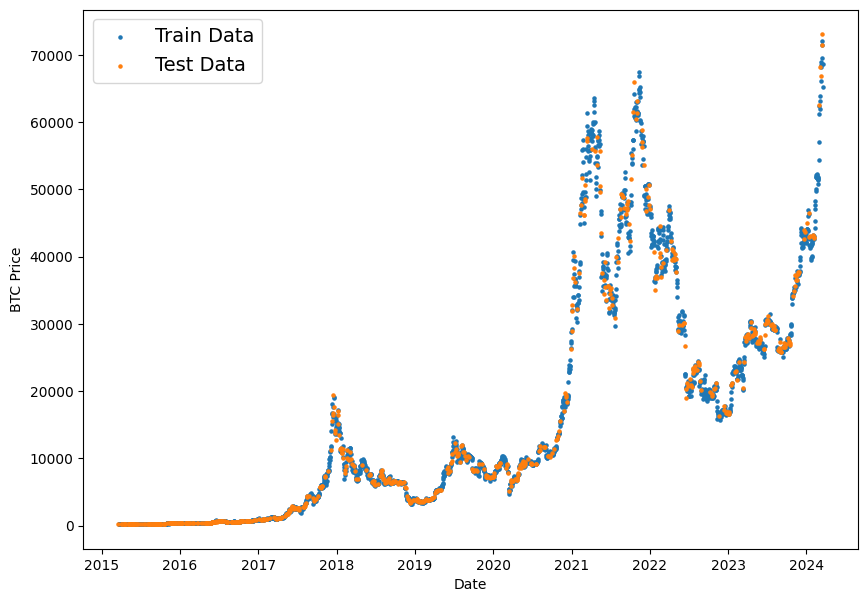

In [15]:
# Let's plot wrong train/test split
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label="Train Data")
plt.scatter(X_test, y_test, s=5, label="Test Data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show()

### Create train and test sets for time series data the right way

In [16]:
# Create train and test splits for time series data the right way
split_size = int(0.8 * len(prices)) # 80% train and 20% test - you can change these values as needed (eg. 90/10, 95/5)

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything beyond the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2629, 658, 2629, 658)

In [17]:
# Plot correctly made splits

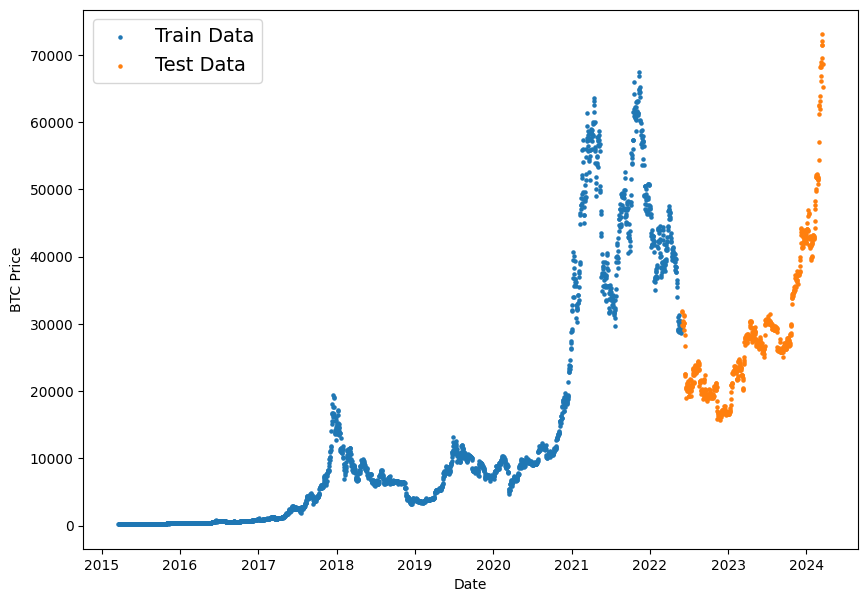

In [18]:
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label="Train Data")
plt.scatter(X_test, y_test, s=5, label="Test Data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show()

## Create a plotting function

Because typing plotting code is tedious, let's functionize it

In [19]:
def create_graph(X_train, y_train, X_test, y_test, train_label, test_label, x_label, y_label):    #Mark's function
  '''
  Creates a graph of training data, testing data.

  Args:
  X_train: training values
  y_train: training labels
  X_test: test values
  y_test: test labels
  train_label: training labels
  test_label: test labels
  x_label: label (caption) of the x-axis
  y_label: label (caption) of the y-axis

  Returns:

  '''
  plt.figure(figsize=(10,7))
  plt.scatter(X_train, y_train, s=5, label=train_label)
  plt.scatter(X_test, y_test, s=5, label=test_label)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.legend(fontsize=14)
  plt.show()

In [20]:
# Creat a function to plot time series data (Daniel's function)

def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
  #plot the series
  '''
  Plots timesteps (a series of points in time) against values (a series of values across timesteps)

  Parameters
  ----------
  timesteps: array of timestep values
  values: array of values across time
  format: style of plot, default "."
  start: where to start the plot (setting a value will index from start of timesteps & values)
  end: where to end the plot (similar to start but for the end)
  label: label to show on plot about values, default None
  '''

  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")

  if label:
    plt.legend(fontsize=14)  # make label bigger

  plt.grid(True)

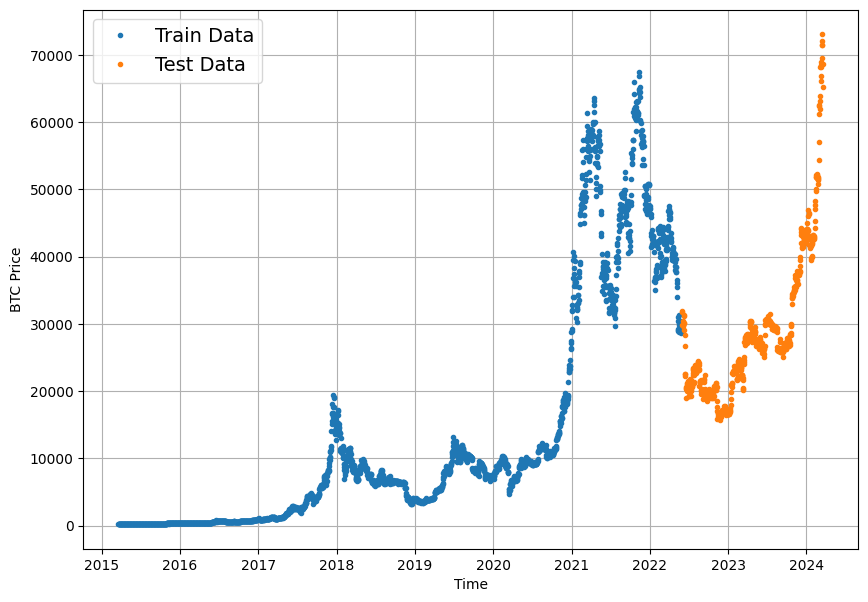

In [21]:
# Test out plotting function
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_train, values=y_train, label="Train Data")
plot_time_series(timesteps=X_test, values=y_test, label="Test Data")

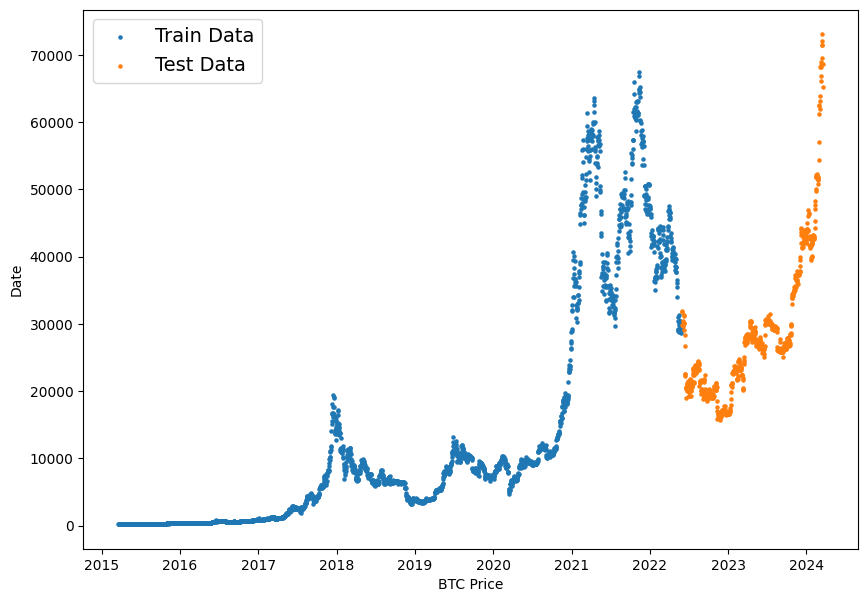

In [22]:
create_graph(X_train, y_train, X_test, y_test, "Train Data", "Test Data", "BTC Price", "Date")

## Modelling experiments ##

We've got some bitcoin historical data, to model it, let's run a series of modelling experiments and see which one performs best.

Terms to be familiar with:
* **Horizon**: number of steps into the future to predict
* **Window size**: number of time steps we're going to use to predict **horizon**

Modelling experiments we're running
* 0	Naïve model (baseline)
* 1	Dense model, horizon=1, window=7
* 2	Same as 1, horizon=1, window=30
* 3	Same as 1, horizon=7, window=30
* 4	Conv1D
* 5	LSTM
* 6	Same as 1 (but with multivariate data)
* 7	N-BEATs Algorithm
* 8	Ensemble (multiple models optimized on different loss functions)
* 9	Future prediction model (model to predict future values)
* 10	Same as 1 (but with turkey 🦃 data introduced)

## Model 0: Naive forecase (baseline)

$$\hat{y}_{t} = y_{t-1}$$

In English:

> The prediction at timestep t (y-hat) is equal to the value at timestep t-1 (previous timestep) - this is for a horizon of 1.

In [23]:
# Create a naive forecast
naive_forecast = y_test[:-1]

In [24]:
y_test[:10], y_test[-10:]

(array([31720.0295    , 31852.83438319, 29789.42113357, 30441.46505023,
        29717.55804642, 29840.07521594, 29909.21037334, 31367.42259841,
        31193.0692    , 30204.54858261]),
 array([68202.87, 68513.59, 68949.74, 72094.44, 71473.86, 73087.95,
        71432.39, 69532.18, 65286.52, 68650.08]))

In [25]:
naive_forecast[:10], naive_forecast[-10:]

(array([31720.0295    , 31852.83438319, 29789.42113357, 30441.46505023,
        29717.55804642, 29840.07521594, 29909.21037334, 31367.42259841,
        31193.0692    , 30204.54858261]),
 array([66903.82, 68202.87, 68513.59, 68949.74, 72094.44, 71473.86,
        73087.95, 71432.39, 69532.18, 65286.52]))

In [26]:
y_test[10], naive_forecast[10]

(30111.70675013388, 30111.70675013388)

In [27]:
X_test[10], y_test[10]

(numpy.datetime64('2022-06-10T00:00:00.000000000'), 30111.70675013388)

In [28]:
X_test[11], naive_forecast[10]

(numpy.datetime64('2022-06-11T00:00:00.000000000'), 30111.70675013388)

In [29]:
X_test[:10]

array(['2022-05-31T00:00:00.000000000', '2022-06-01T00:00:00.000000000',
       '2022-06-02T00:00:00.000000000', '2022-06-03T00:00:00.000000000',
       '2022-06-04T00:00:00.000000000', '2022-06-05T00:00:00.000000000',
       '2022-06-06T00:00:00.000000000', '2022-06-07T00:00:00.000000000',
       '2022-06-08T00:00:00.000000000', '2022-06-09T00:00:00.000000000'],
      dtype='datetime64[ns]')

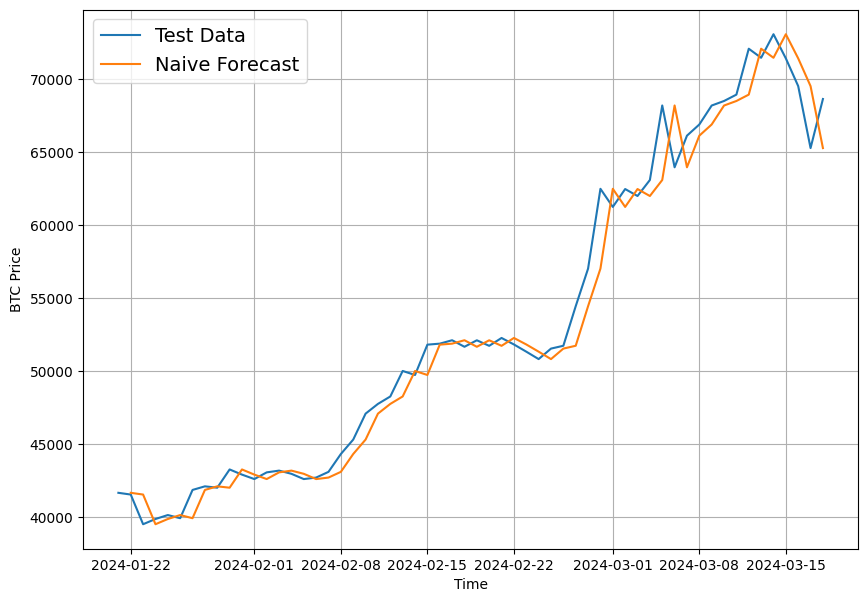

In [30]:
# Plot naive forecast
plt.figure(figsize=(10,7))
#plot_time_series(timesteps=X_train, values=y_train, label="Train Data")
plot_time_series(timesteps=X_test, values=y_test, format="-", start=600, label="Test Data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", start=600, label="Naive Forecast")

### Important note!!  The reason the forecast is behind the test data is because our data goes from newest to oldest, unlike Daniel's video! ...?

** Exercise: ** Spend 10 minutes reading the simple forecasts chapter of Forecasting Principles in Practice and have a search to find out why the naive forecast is hard to beat.  Does the term Auto-Regressive come up?

## Evaluating a time series model

Let's look into some evaluation metrics for time series forecasting

What are we doing?  We are predicting a number, so that means we have a form of regression problem.  

Because we're working on a regression problem, we will need some regression-like metrics.

A few common regression metrics which can also be used for time series forecasting:
* MAE - mean absolute error
* MSE - mean squared error
* RMSE - root mean square error
* MAPE/sMAPE - (symmetric) mean absolute percentage error
* MASE - mean absolute scaled error

For all of the above metrics, **lower is better** , for example, an MAE of 0 that is better than an MAE of 100.  

The main thing we're evaluating here is  **how do our model's forecast (y_pred) compare against the actual values (y_true or ground truth values)?**

** Resource: ** For a deeper dive into the various kinds of time series forecasting methods see https://otexts.com/fpp3/accuracy.html


In [31]:
import tensorflow as tf

# MASE imeplementation

def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:]-y_true[:-1])) # our seasonality is 1 day, hence the shift of 1

  return mae / mae_naive_no_season

In [32]:
print(mean_absolute_scaled_error(y_true=y_test[1:], y_pred=naive_forecast))

tf.Tensor(0.998866514773403, shape=(), dtype=float64)


### Challenge:
Write a function that take y_true and y_pred, and returns:

* MAE - mean absolute error
* MSE - mean squared error
* RMSE - root mean square error
* MAPE/sMAPE - (symmetric) mean absolute percentage error
* MASE - mean absolute scaled error

in dictionary form.

In [33]:
from sklearn.metrics import mean_absolute_error as mean_absolute_error
from sklearn.metrics import mean_squared_error as mean_squared_error
from math import sqrt
from sklearn.metrics import mean_absolute_percentage_error as mean_absolute_percentage_error

In [34]:
# Old evaluate_preds function made by mark.  Did not work anymore for ensemble_models, probably because sklearn functions cannot handle additional dimensions.

def evaluate_preds_old(y_true, y_pred):
  regression_preds = {}
  """
  Take y_true and y_pred and returns dictionary of 5 regression metrics:
  MAE - mean absolute error
  MSE - mean squared error
  RMSE - root mean square error
  MAPE/sMAPE - (symmetric) mean absolute percentage error
  MASE - mean absolute scaled error
  """
  y_true = tf.cast(y_true, tf.float32)

  mae = mean_absolute_error(y_true,y_pred)
  mse = mean_squared_error(y_true,y_pred)
  rmse = sqrt(mse)
  mape = mean_absolute_percentage_error(y_true,y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred).numpy()

  regression_preds = {"mae":mae,
                      "mse":mse,
                      "rmse":rmse,
                      "mape":mape,
                      "mase":mase}

  return regression_preds

In [35]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [36]:
print(evaluate_preds(y_true=y_test[1:],y_pred=naive_forecast))
naive_results=evaluate_preds(y_true=y_test[1:],y_pred=naive_forecast)

{'mae': 519.6014, 'mse': 722598.1, 'rmse': 850.0577, 'mape': 1.788741, 'mase': 0.99886644}


## Other models you can use for baseline and for actual forecasts

In this notebook, we are focused on TensorFlow and deep learning models, however there are plenty of other styles of time series forecasting models you may want to experiment with:

https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/#other-kinds-of-time-series-forecasting-models-which-can-be-used-for-baselines-and-actual-forecasts



## Format Part 2: Windowing Our Data Set

Why do we window?

We window our time series dataset to turn our data into a supervised learning problem.  
'''
Windowing for one week:
* [0,1,2,3,4,5,6] -> [7]
* [1,2,3,4,5,6,7] -> [8]
* [2,3,4,5,6,7,8] -> [9]

In [37]:
bitcoin_prices[:8]

,Price
Date,
2015-03-20,260.741
2015-03-21,261.829
2015-03-22,260.018
2015-03-23,267.969
2015-03-24,266.682
2015-03-25,245.055
2015-03-26,246.081
2015-03-27,248.482


In [38]:
btc_price=bitcoin_prices["Price"].to_list()

In [39]:
btc_price[:5]

[260.741, 261.829, 260.018, 267.969, 266.682]

In [40]:
# What we want to do with our bitcoin data
print(f'We want to use {btc_price[:7]} to predict {btc_price[7]}')

We want to use [260.741, 261.829, 260.018, 267.969, 266.682, 245.055, 246.081] to predict 248.482


In [41]:
# Let's setup global variables for window and horizon size
HORIZON = 1 # Predict next one day
WINDOW_SIZE = 7 # use the past week of bitcoin data to make a prediction

# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed data set

  E.g. if horizon = 1
  Input: [0,1,2,3,4,5,6,7] -> [8]
  """
  #feature=x[:-horizon]
  #label=x[-horizon:]
  #return feature, label

  return x[:, :-horizon], x[:, -horizon:]



In [42]:
# Test out the window labelling function
#test_window, test_label = get_labelled_windows(tf.range(8)+1)
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0))
print(test_window, test_label)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label.numpy())}")

tf.Tensor([[1 2 3 4 5 6 7]], shape=(1, 7), dtype=int32) tf.Tensor([[8]], shape=(1, 1), dtype=int32)
Window: [1 2 3 4 5 6 7] -> Label: 8


We've got a way to label our windowed data

However, this only works on a small scale

We need a way to do the above across our entire time series.

We could do this with Python for loops, however for large time series that would be quite slow.

To speed things up, we'll leverage NumPy's array indexing. https://numpy.org/doc/stable/user/basics.indexing.html

Our function will:
1. It will create a window step of specific window size (eg. [0, 1, 2, 3, 4, 5, 6])
2. Use NumPy indexing to create a 2D array of multiple window steps, for example:
```
[[0, 1, 2, 3, 4, 5, 6],
[1, 2, 3, 4, 5, 6, 7],
[2, 3, 4, 5, 6, 7, 8]]
```
3. Uses the 2D array of multiple window steps (from 2.) to index on a target series (e.g. the historical price of bitcoin)
4. Uses our `get_labelled_windows()` function created above to turn the window steps into windows with a specified horizon.

> **Resource** The function we are about to create was adapted from the following article: https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5

In [43]:
import numpy as np

# Create function to view NumPy arrays as windows
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
  """
  Turns a 1D array into 2D array of sequential labelled windows of window_size with horizon size labels.
  """
  # 1. Create a window of specific window size (add the horizon on the end for labelling later)
  window_step=np.expand_dims(np.arange(window_size+horizon), axis=0)

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size

  print(f"Window indexes:\n {window_indexes, window_indexes.shape}")

  # 3. Index on the target array (a time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
  return windows,labels


In [44]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

full_windows_30, full_labels_30 = make_windows(prices, window_size=30, horizon=HORIZON)
len(full_windows_30), len(full_labels_30)

Window indexes:
 (array([[   0,    1,    2, ...,    5,    6,    7],
       [   1,    2,    3, ...,    6,    7,    8],
       [   2,    3,    4, ...,    7,    8,    9],
       ...,
       [3277, 3278, 3279, ..., 3282, 3283, 3284],
       [3278, 3279, 3280, ..., 3283, 3284, 3285],
       [3279, 3280, 3281, ..., 3284, 3285, 3286]]), (3280, 8))
Window indexes:
 (array([[   0,    1,    2, ...,   28,   29,   30],
       [   1,    2,    3, ...,   29,   30,   31],
       [   2,    3,    4, ...,   30,   31,   32],
       ...,
       [3254, 3255, 3256, ..., 3282, 3283, 3284],
       [3255, 3256, 3257, ..., 3283, 3284, 3285],
       [3256, 3257, 3258, ..., 3284, 3285, 3286]]), (3257, 31))


(3257, 3257)

In [45]:
full_windows, full_labels

(array([[  260.741,   261.829,   260.018, ...,   266.682,   245.055,
           246.081],
        [  261.829,   260.018,   267.969, ...,   245.055,   246.081,
           248.482],
        [  260.018,   267.969,   266.682, ...,   246.081,   248.482,
           247.066],
        ...,
        [68202.87 , 68513.59 , 68949.74 , ..., 71473.86 , 73087.95 ,
         71432.39 ],
        [68513.59 , 68949.74 , 72094.44 , ..., 73087.95 , 71432.39 ,
         69532.18 ],
        [68949.74 , 72094.44 , 71473.86 , ..., 71432.39 , 69532.18 ,
         65286.52 ]]),
 array([[  248.482],
        [  247.066],
        [  252.89 ],
        ...,
        [69532.18 ],
        [65286.52 ],
        [68650.08 ]]))

In [46]:
full_windows_30, full_labels_30

(array([[  260.741,   261.829,   260.018, ...,   223.656,   228.615,
           222.951],
        [  261.829,   260.018,   267.969, ...,   228.615,   222.951,
           223.417],
        [  260.018,   267.969,   266.682, ...,   222.951,   223.417,
           222.604],
        ...,
        [51819.74 , 51888.33 , 52121.96 , ..., 71473.86 , 73087.95 ,
         71432.39 ],
        [51888.33 , 52121.96 , 51673.99 , ..., 73087.95 , 71432.39 ,
         69532.18 ],
        [52121.96 , 51673.99 , 52119.06 , ..., 71432.39 , 69532.18 ,
         65286.52 ]]),
 array([[  223.417],
        [  222.604],
        [  224.645],
        ...,
        [69532.18 ],
        [65286.52 ],
        [68650.08 ]]))

In [47]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [260.741 261.829 260.018 267.969 266.682 245.055 246.081] -> Label: [248.482]
Window: [261.829 260.018 267.969 266.682 245.055 246.081 248.482] -> Label: [247.066]
Window: [260.018 267.969 266.682 245.055 246.081 248.482 247.066] -> Label: [252.89]


In [48]:
# View the first 3 windows/labels of 30 window size
for i in range(3):
  print(f"Window: {full_windows_30[i]} -> Label: {full_labels_30[i]}")

Window: [260.741 261.829 260.018 267.969 266.682 245.055 246.081 248.482 247.066
 252.89  242.637 247.657 244.14  247.289 253.024 254.321 253.83  260.451
 255.527 253.451 245.084 243.744 235.881 236.637 236.071 224.81  219.163
 223.656 228.615 222.951] -> Label: [223.417]
Window: [261.829 260.018 267.969 266.682 245.055 246.081 248.482 247.066 252.89
 242.637 247.657 244.14  247.289 253.024 254.321 253.83  260.451 255.527
 253.451 245.084 243.744 235.881 236.637 236.071 224.81  219.163 223.656
 228.615 222.951 223.417] -> Label: [222.604]
Window: [260.018 267.969 266.682 245.055 246.081 248.482 247.066 252.89  242.637
 247.657 244.14  247.289 253.024 254.321 253.83  260.451 255.527 253.451
 245.084 243.744 235.881 236.637 236.071 224.81  219.163 223.656 228.615
 222.951 223.417 222.604] -> Label: [224.645]


In [49]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [68202.87 68513.59 68949.74 72094.44 71473.86 73087.95 71432.39] -> Label: [69532.18]
Window: [68513.59 68949.74 72094.44 71473.86 73087.95 71432.39 69532.18] -> Label: [65286.52]
Window: [68949.74 72094.44 71473.86 73087.95 71432.39 69532.18 65286.52] -> Label: [68650.08]


> ** Note: ** There's a function which does similar to the above in tf.keras.preprocessing, an extension could be to try and replicate what we've done using the pre-made function. https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array

In [50]:
from keras.preprocessing import timeseries_dataset_from_array

result = timeseries_dataset_from_array(prices, None, WINDOW_SIZE)
print(result)

<_BatchDataset element_spec=TensorSpec(shape=(None, None), dtype=tf.float64, name=None)>


## Turning windows into training and test sets

In [51]:
full_windows[:5], full_labels[:5]

(array([[260.741, 261.829, 260.018, 267.969, 266.682, 245.055, 246.081],
        [261.829, 260.018, 267.969, 266.682, 245.055, 246.081, 248.482],
        [260.018, 267.969, 266.682, 245.055, 246.081, 248.482, 247.066],
        [267.969, 266.682, 245.055, 246.081, 248.482, 247.066, 252.89 ],
        [266.682, 245.055, 246.081, 248.482, 247.066, 252.89 , 242.637]]),
 array([[248.482],
        [247.066],
        [252.89 ],
        [242.637],
        [247.657]]))

In [52]:
# Make the train / test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits
  """
  split_size=int(len(windows) * (1-test_split)) # this will default to 80% train, 20% test
  train_windows=windows[:split_size]
  train_labels=labels[:split_size]
  test_windows=windows[split_size:]
  test_labels=labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [53]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2624, 656, 2624, 656)

In [54]:
train_windows_30, test_windows_30, train_labels_30, test_labels_30 = make_train_test_splits(full_windows_30, full_labels_30)
len(train_windows_30), len(test_windows_30), len(train_labels_30), len(test_labels_30)

(2605, 652, 2605, 652)

In [55]:
train_windows_30.shape, train_labels_30.shape, y_train.shape

((2605, 30), (2605, 1), (2629,))

In [56]:
train_windows[:5], train_labels[:5]

(array([[260.741, 261.829, 260.018, 267.969, 266.682, 245.055, 246.081],
        [261.829, 260.018, 267.969, 266.682, 245.055, 246.081, 248.482],
        [260.018, 267.969, 266.682, 245.055, 246.081, 248.482, 247.066],
        [267.969, 266.682, 245.055, 246.081, 248.482, 247.066, 252.89 ],
        [266.682, 245.055, 246.081, 248.482, 247.066, 252.89 , 242.637]]),
 array([[248.482],
        [247.066],
        [252.89 ],
        [242.637],
        [247.657]]))

In [57]:
test_windows[:5],test_labels[:5]

(array([[29557.53373564, 29353.61926283, 28606.47447262, 29047.06026877,
         29445.7241    , 31720.0295    , 31852.83438319],
        [29353.61926283, 28606.47447262, 29047.06026877, 29445.7241    ,
         31720.0295    , 31852.83438319, 29789.42113357],
        [28606.47447262, 29047.06026877, 29445.7241    , 31720.0295    ,
         31852.83438319, 29789.42113357, 30441.46505023],
        [29047.06026877, 29445.7241    , 31720.0295    , 31852.83438319,
         29789.42113357, 30441.46505023, 29717.55804642],
        [29445.7241    , 31720.0295    , 31852.83438319, 29789.42113357,
         30441.46505023, 29717.55804642, 29840.07521594]]),
 array([[29789.42113357],
        [30441.46505023],
        [29717.55804642],
        [29840.07521594],
        [29909.21037334]]))

In [58]:
y_train[WINDOW_SIZE:]

array([  248.482     ,   247.066     ,   252.89      , ...,
       28606.47447262, 29047.06026877, 29445.7241    ])

In [59]:
y_train[-10:]

array([29234.03290986, 29449.98555992, 30366.04222096, 29114.08113115,
       29674.1123    , 29557.53373564, 29353.61926283, 28606.47447262,
       29047.06026877, 29445.7241    ])

In [60]:
len(full_labels_30)

3257

In [61]:
len(y_train)

2629

In [62]:
train_labels_30[-10:]

array([[29353.61926283],
       [28606.47447262],
       [29047.06026877],
       [29445.7241    ],
       [31720.0295    ],
       [31852.83438319],
       [29789.42113357],
       [30441.46505023],
       [29717.55804642],
       [29840.07521594]])

In [63]:
train_labels[:-HORIZON-1]

array([[  248.482     ],
       [  247.066     ],
       [  252.89      ],
       ...,
       [28606.47447262],
       [29047.06026877],
       [29445.7241    ]])

In [64]:
train_labels[-10:]

array([[30366.04222096],
       [29114.08113115],
       [29674.1123    ],
       [29557.53373564],
       [29353.61926283],
       [28606.47447262],
       [29047.06026877],
       [29445.7241    ],
       [31720.0295    ],
       [31852.83438319]])

In [65]:
y_train[27:]

array([  223.656     ,   228.615     ,   222.951     , ...,
       28606.47447262, 29047.06026877, 29445.7241    ])

In [66]:
len(y_train), len(train_labels)

(2629, 2624)

In [67]:
train_labels[:-2]

array([[  248.482     ],
       [  247.066     ],
       [  252.89      ],
       ...,
       [28606.47447262],
       [29047.06026877],
       [29445.7241    ]])

In [68]:
y_test[WINDOW_SIZE:]

array([31367.42259841, 31193.0692    , 30204.54858261, 30111.70675013,
       29082.53195031, 28399.9749    , 26704.72935718, 22509.0994    ,
       22209.515     , 22490.59072731, 20383.6889    , 20468.2145    ,
       19007.5031    , 20554.9027    , 20672.8011    , 20739.94338572,
       19976.05359135, 21075.1688    , 21279.53232918, 21499.97103713,
       21029.2163    , 20732.9834    , 20293.4508    , 20101.12      ,
       19816.74635993, 19336.10444109, 19246.50948843, 19310.0755    ,
       20255.6454    , 20185.96232828, 20557.53554927, 21647.16592841,
       21801.08220543, 21592.7417482 , 20857.65583736, 19992.29456703,
       19313.26076323, 20187.1528    , 20587.5358    , 20831.3113719 ,
       21192.11367285, 20769.4022573 , 22440.03658413, 23407.3451    ,
       23244.5742    , 23180.0875    , 22701.085     , 22471.31570307,
       22600.78471407, 21340.4673    , 21206.71524384, 22943.12042342,
       23847.01344274, 23746.2734    , 23642.24323411, 23314.4296    ,
      

In [69]:
test_labels[:-2]

array([[29789.42113357],
       [30441.46505023],
       [29717.55804642],
       [29840.07521594],
       [29909.21037334],
       [31367.42259841],
       [31193.0692    ],
       [30204.54858261],
       [30111.70675013],
       [29082.53195031],
       [28399.9749    ],
       [26704.72935718],
       [22509.0994    ],
       [22209.515     ],
       [22490.59072731],
       [20383.6889    ],
       [20468.2145    ],
       [19007.5031    ],
       [20554.9027    ],
       [20672.8011    ],
       [20739.94338572],
       [19976.05359135],
       [21075.1688    ],
       [21279.53232918],
       [21499.97103713],
       [21029.2163    ],
       [20732.9834    ],
       [20293.4508    ],
       [20101.12      ],
       [19816.74635993],
       [19336.10444109],
       [19246.50948843],
       [19310.0755    ],
       [20255.6454    ],
       [20185.96232828],
       [20557.53554927],
       [21647.16592841],
       [21801.08220543],
       [21592.7417482 ],
       [20857.65583736],


In [70]:
HORIZON

1

In [71]:
WINDOW_SIZE

7

In [72]:
# Check to see if train labels are the same (before and after window split)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

In [73]:
len(train_labels[:-HORIZON-1]), len(y_train[WINDOW_SIZE:])

(2622, 2622)

In [74]:
# Check to see if train labels are the same for 30 window size (before and after window split)

np.array_equal(np.squeeze(train_labels_30[:-HORIZON-5]), y_train[WINDOW_SIZE+23:])

True

In [75]:
y_train[-30:]

array([37660.45292214, 38467.094     , 38503.90959019, 37732.29975232,
       39699.03395918, 36568.7596    , 36033.0634    , 35552.564     ,
       33933.54281003, 30363.86561662, 31024.7033    , 28984.5358    ,
       29130.0386    , 29250.004     , 30123.7756    , 31333.76561707,
       29880.54816423, 30452.62432833, 28760.1539    , 30376.33147861,
       29234.03290986, 29449.98555992, 30366.04222096, 29114.08113115,
       29674.1123    , 29557.53373564, 29353.61926283, 28606.47447262,
       29047.06026877, 29445.7241    ])

In [76]:
train_labels_30[-10:]

array([[29353.61926283],
       [28606.47447262],
       [29047.06026877],
       [29445.7241    ],
       [31720.0295    ],
       [31852.83438319],
       [29789.42113357],
       [30441.46505023],
       [29717.55804642],
       [29840.07521594]])

In [77]:
len(train_labels_30[:-2])

2603

In [78]:
len(y_train[30:])

2599

In [79]:
train_labels[HORIZON]

array([247.066])

In [80]:
np.array_equal(y_train[WINDOW_SIZE+1], np.squeeze(train_labels[HORIZON]))

True

In [81]:
np.squeeze(train_labels).shape, y_train.shape

((2624,), (2629,))

In [82]:
np.array_equal(np.squeeze(train_windows[:-HORIZON-1]), X_train[WINDOW_SIZE:])

False

In [83]:
# Check to see if train labels are the same (before and after window split)
np.array_equal(np.squeeze(test_labels[:-HORIZON-1]), y_test[WINDOW_SIZE:])

False

## Make a modelling checkpoint callback

Because our model's performane will fluctuate from experiment to experiment, we're going to write a model checkpoint so we can compare apples to apples.  

More specifically, we want to compare each of our model's best performances against our other model's best performances.  

For example, if our model performs the best on epoch 55 (but we're training for 100 epochs), we want to load and evaluate the model saved on epoch 55.  

We can create a modelling checkpoint callback using the following:
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint



In [84]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename.
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True)

## Model 1: Dense model (window = 7, horizon = 1)

Our first deep model is going to a simple dense model:

* A single dense layer with 128 hidden units and RELU activation
* Output layer with linear activation (no activation)
* Adam optimizer and MAE loss function
* Batch size of 128 (previously we've used 32)
* 100 epochs

Why these values?

I picked them out of experimentation.  

* *Hyperparameters* = values a machine learning practitioner (you!) can adjust himself
* *Parameters* = values a model learns on its own



In [85]:
import tensorflow as tf
from tensorflow.keras import layers

#set random seed for as reproducible results as possible
tf.random.set_seed(42)

# 1. Construct model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear") # linear activation is the same as having no activation
    ], name="model_1_dense") # name our model so we can save it

# 2. Compile
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae", "mse"])

#3. Fit the model
model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_1.name)])

Epoch 1/100
21/21 [==============================] - 2s 49ms/step - loss: 9811.2354 - mae: 9811.2354 - mse: 329668224.0000 - val_loss: 1006.7059 - val_mae: 1006.7059 - val_mse: 2056575.6250
Epoch 2/100
21/21 [==============================] - 0s 5ms/step - loss: 1445.0626 - mae: 1445.0626 - mse: 7769557.0000 - val_loss: 2143.3289 - val_mae: 2143.3289 - val_mse: 7216690.5000
Epoch 3/100
21/21 [==============================] - 0s 23ms/step - loss: 727.4094 - mae: 727.4094 - mse: 2173483.2500 - val_loss: 912.3199 - val_mae: 912.3199 - val_mse: 2054678.6250
Epoch 4/100
21/21 [==============================] - 0s 24ms/step - loss: 620.2122 - mae: 620.2122 - mse: 1668106.7500 - val_loss: 885.0712 - val_mae: 885.0712 - val_mse: 1710990.8750
Epoch 5/100
21/21 [==============================] - 0s 23ms/step - loss: 588.7595 - mae: 588.7595 - mse: 1492267.5000 - val_loss: 818.3759 - val_mae: 818.3759 - val_mse: 1574935.1250
Epoch 6/100
21/21 [==============================] - 0s 22ms/step - los

In [86]:
naive_results

{'mae': 519.6014,
 'mse': 722598.1,
 'rmse': 850.0577,
 'mape': 1.788741,
 'mase': 0.99886644}

In [87]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

21/21 [==============================] - 0s 3ms/step - loss: 699.2264 - mae: 699.2264 - mse: 931218.8125


[699.2263793945312, 699.2263793945312, 931218.8125]

In [88]:
# load in saved best performing model_1 and evaluate it on test data
model_1_best = tf.keras.models.load_model("model_experiments/model_1_dense/")
model_1_best.evaluate(test_windows, test_labels)

21/21 [==============================] - 0s 2ms/step - loss: 520.6507 - mae: 520.6507 - mse: 728127.2500


[520.6506958007812, 520.6506958007812, 728127.25]

## Making forecasts with a model

To make forecasts on the test dataset (note: these won't be actual forecasts, they're only pseudo forecasts because actual forecasts are into the future), let's write a function to:

1. Take in a train model
2. Takes in some input data (same kind of data the model was trained on)
3. Pass the input data to the model's `predict()` method
4. Returns the prediction

In [89]:
# model_1_preds = model_1.predict(test_windows)

In [90]:
# model_1_preds[:2], test_windows[:2]

In [91]:
def make_preds(model, test_data):
  """
  Uses model to make predictions on test_data
  """
  return tf.squeeze(model.predict(test_data)) #return 1d array of predictions

In [92]:
# Make predictions using model_1 on the test_dataset and view results

model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds)

21/21 [==============================] - 0s 1ms/step


656

In [93]:
model_1_preds.shape

TensorShape([656])

In [94]:
test_labels.shape

(656, 1)

In [95]:
model_1_results = evaluate_preds(tf.cast(test_labels,tf.float32), model_1_preds)

In [96]:
model_1_results

{'mae': 11040.199,
 'mse': 233284460.0,
 'rmse': 14319.769,
 'mape': 39.67833,
 'mase': 21.31992}

In [97]:
naive_results

{'mae': 519.6014,
 'mse': 722598.1,
 'rmse': 850.0577,
 'mape': 1.788741,
 'mase': 0.99886644}

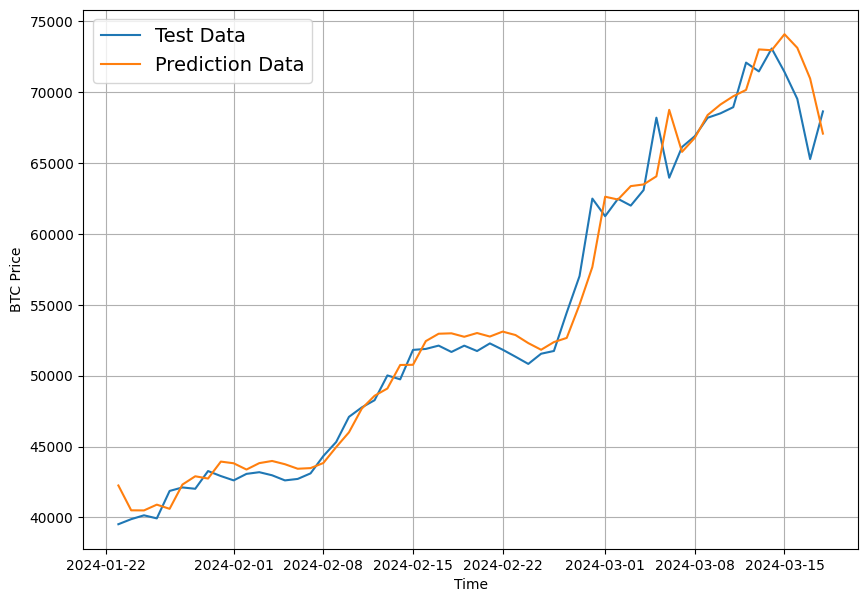

In [98]:
# Let's plot our model 1 predictions
offset = 600
plt.figure(figsize=(10,7))
# Account for the test window offset and index into test labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:, 0],
                 start=offset,
                 format="-",
                 label="Test Data")

plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=model_1_preds,
                 start=offset,
                 format="-",
                 label="Prediction Data")

In [99]:
# Create model 2, with window size = 30


# set random seed for as reproducible results as possible
tf.random.set_seed(42)

# 1. Construct model
model_2 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear")  # linear activation is the same as having no activation
], name="model_2_dense")  # name our model so we can save it

# 2. Compile
model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae","mse"])

# Fit the model
model_2.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_1.name)])

Epoch 1/100
21/21 [==============================] - 1s 29ms/step - loss: 6934.1274 - mae: 6934.1274 - mse: 188541840.0000 - val_loss: 4227.2358 - val_mae: 4227.2358 - val_mse: 21030140.0000
Epoch 2/100
21/21 [==============================] - 0s 22ms/step - loss: 1179.9723 - mae: 1179.9723 - mse: 5645302.0000 - val_loss: 1075.5543 - val_mae: 1075.5543 - val_mse: 2133021.0000
Epoch 3/100
21/21 [==============================] - 0s 23ms/step - loss: 690.5154 - mae: 690.5154 - mse: 1972234.7500 - val_loss: 973.0564 - val_mae: 973.0564 - val_mse: 1918046.8750
Epoch 4/100
21/21 [==============================] - 0s 22ms/step - loss: 626.1717 - mae: 626.1717 - mse: 1710551.6250 - val_loss: 879.8701 - val_mae: 879.8701 - val_mse: 1901545.7500
Epoch 5/100
21/21 [==============================] - 0s 22ms/step - loss: 605.0241 - mae: 605.0241 - mse: 1586706.5000 - val_loss: 848.9465 - val_mae: 848.9465 - val_mse: 1796905.7500
Epoch 6/100
21/21 [==============================] - 0s 23ms/step - l

## Model 2: Dense (window = 30, horizon = 1)



In [100]:
HORIZON = 1 # predict one step at a time (one day of Bitcoin data)
WINDOW_SIZE = 30 # use 30 timesteps in past

In [101]:
# Make window data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)

Window indexes:
 (array([[   0,    1,    2, ...,   28,   29,   30],
       [   1,    2,    3, ...,   29,   30,   31],
       [   2,    3,    4, ...,   30,   31,   32],
       ...,
       [3254, 3255, 3256, ..., 3282, 3283, 3284],
       [3255, 3256, 3257, ..., 3283, 3284, 3285],
       [3256, 3257, 3258, ..., 3284, 3285, 3286]]), (3257, 31))


In [102]:
len(full_windows), len(full_labels)

(3257, 3257)

In [103]:
# Make train and test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2605, 652, 2605, 652)

In [104]:
train_windows[:3], train_labels[:3]

(array([[260.741, 261.829, 260.018, 267.969, 266.682, 245.055, 246.081,
         248.482, 247.066, 252.89 , 242.637, 247.657, 244.14 , 247.289,
         253.024, 254.321, 253.83 , 260.451, 255.527, 253.451, 245.084,
         243.744, 235.881, 236.637, 236.071, 224.81 , 219.163, 223.656,
         228.615, 222.951],
        [261.829, 260.018, 267.969, 266.682, 245.055, 246.081, 248.482,
         247.066, 252.89 , 242.637, 247.657, 244.14 , 247.289, 253.024,
         254.321, 253.83 , 260.451, 255.527, 253.451, 245.084, 243.744,
         235.881, 236.637, 236.071, 224.81 , 219.163, 223.656, 228.615,
         222.951, 223.417],
        [260.018, 267.969, 266.682, 245.055, 246.081, 248.482, 247.066,
         252.89 , 242.637, 247.657, 244.14 , 247.289, 253.024, 254.321,
         253.83 , 260.451, 255.527, 253.451, 245.084, 243.744, 235.881,
         236.637, 236.071, 224.81 , 219.163, 223.656, 228.615, 222.951,
         223.417, 222.604]]),
 array([[223.417],
        [222.604],
        [224

In [105]:
# Create model 2
tf.random.set_seed(42)

# Create model
model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(HORIZON, activation="linear"),
    ], name="model_2_dense")

# Compile model
model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae","mse"])

# Fit the model
model_2.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_2.name)])

Epoch 1/100
21/21 [==============================] - 2s 45ms/step - loss: 1734.4141 - mae: 1734.4141 - mse: 12079014.0000 - val_loss: 1690.4220 - val_mae: 1690.4220 - val_mse: 4953308.5000
Epoch 2/100
21/21 [==============================] - 0s 23ms/step - loss: 939.7236 - mae: 939.7236 - mse: 3561968.0000 - val_loss: 1194.5612 - val_mae: 1194.5612 - val_mse: 3284127.0000
Epoch 3/100
21/21 [==============================] - 0s 5ms/step - loss: 814.3444 - mae: 814.3444 - mse: 2722752.5000 - val_loss: 1375.1722 - val_mae: 1375.1722 - val_mse: 3136485.0000
Epoch 4/100
21/21 [==============================] - 0s 22ms/step - loss: 734.1185 - mae: 734.1185 - mse: 2180395.5000 - val_loss: 931.6171 - val_mae: 931.6171 - val_mse: 1982876.8750
Epoch 5/100
21/21 [==============================] - 0s 22ms/step - loss: 662.7818 - mae: 662.7818 - mse: 1872451.0000 - val_loss: 893.3921 - val_mae: 893.3921 - val_mse: 1832397.7500
Epoch 6/100
21/21 [==============================] - 1s 31ms/step - loss

In [106]:
# Evaluate model 2 on test data
model_2.evaluate(test_windows, test_labels)

21/21 [==============================] - 0s 2ms/step - loss: 555.5996 - mae: 555.5996 - mse: 792807.7500


[555.599609375, 555.599609375, 792807.75]

In [107]:
# Load in the best performing model
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows, test_labels)

21/21 [==============================] - 0s 2ms/step - loss: 545.4062 - mae: 545.4062 - mse: 773956.5000


[545.4061889648438, 545.4061889648438, 773956.5]

In [108]:
# Get the forecast predictions
model_2_preds = make_preds(model_2, test_windows)

21/21 [==============================] - 0s 2ms/step


In [109]:
model_2_preds

<tf.Tensor: shape=(652,), dtype=float32, numpy=
array([29599.15 , 29354.516, 30659.037, 31368.367, 30681.809, 30145.766,
       29131.316, 28392.041, 26986.977, 23550.617, 21747.95 , 22227.172,
       21068.168, 20749.285, 19310.705, 20200.066, 20696.363, 20604.672,
       20234.672, 20679.088, 21706.836, 21606.277, 21192.959, 20591.016,
       20618.941, 19785.896, 19987.861, 18943.793, 19249.23 , 19391.652,
       20154.443, 19896.975, 20497.607, 21138.562, 21569.795, 21633.002,
       20659.395, 19912.307, 19392.887, 19790.97 , 20254.785, 20716.562,
       21009.102, 20935.656, 22001.64 , 22988.84 , 23360.139, 23366.818,
       22895.945, 22668.191, 22601.455, 21624.486, 21140.785, 22245.05 ,
       23497.037, 24023.908, 23585.94 , 23520.84 , 23582.084, 23150.56 ,
       22809.773, 22605.68 , 23041.896, 23245.648, 23070.598, 23417.062,
       23282.947, 23793.062, 23799.54 , 24348.732, 24494.81 , 24576.982,
       24480.93 , 23865.44 , 23319.418, 22978.305, 21278.568, 20851.139,
   

In [110]:
model_2_results = evaluate_preds(tf.cast(test_labels,tf.float32), model_2_preds)

In [111]:
model_2_results

{'mae': 10982.523,
 'mse': 231657170.0,
 'rmse': 14201.503,
 'mape': 39.103607,
 'mase': 21.176895}

In [112]:
model_1_results

{'mae': 11040.199,
 'mse': 233284460.0,
 'rmse': 14319.769,
 'mape': 39.67833,
 'mase': 21.31992}

In [113]:
naive_results

{'mae': 519.6014,
 'mse': 722598.1,
 'rmse': 850.0577,
 'mape': 1.788741,
 'mase': 0.99886644}

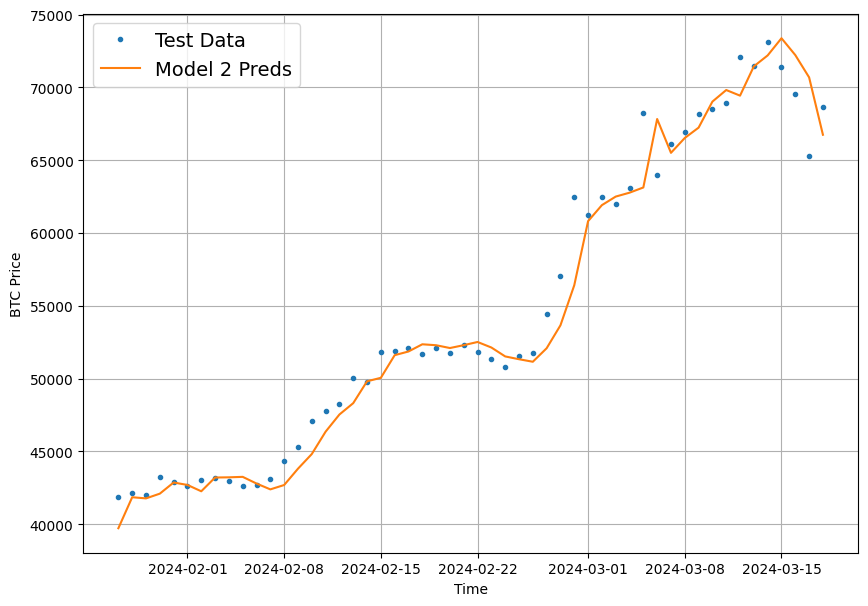

In [114]:
offset=600
plt.figure(figsize=(10,7))
# Account for test window offset when plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:,0], start=offset, label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="Model 2 Preds")

In [115]:
len(X_test[-len(test_windows):])

652

In [116]:
len(X_test)

658

In [117]:
len(test_windows)

652

## Model 3: Dense (Window=30, Horizon=7)



In [118]:
HORIZON=7
WINDOW_SIZE=30

In [119]:
# Make full windows and full labels
full_windows, full_labels = make_windows(prices, WINDOW_SIZE, HORIZON)

Window indexes:
 (array([[   0,    1,    2, ...,   34,   35,   36],
       [   1,    2,    3, ...,   35,   36,   37],
       [   2,    3,    4, ...,   36,   37,   38],
       ...,
       [3248, 3249, 3250, ..., 3282, 3283, 3284],
       [3249, 3250, 3251, ..., 3283, 3284, 3285],
       [3250, 3251, 3252, ..., 3284, 3285, 3286]]), (3251, 37))


In [120]:
len(full_windows), len(full_labels)

(3251, 3251)

In [121]:
full_windows.shape, full_labels.shape

((3251, 30), (3251, 7))

In [122]:
# Make train and test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)

In [123]:
len(train_windows), len(train_labels)

(2600, 2600)

In [ ]:
# Create model 3
tf.random.set_seed(42)

model_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(HORIZON, activation="linear")
], name="model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae","mse"])

model_3.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=32,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_3.name)])

In [ ]:
# Evaluate the model on the test data
model_3.evaluate(test_windows, test_labels)

In [ ]:
# Load best version of model 3 and evaluate
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense")
model_3.evaluate(test_windows,test_labels)

In [ ]:
model_3_preds = make_preds(model_3, test_windows)
model_3_preds[:5]

In [ ]:
tf.squeeze(test_labels)

In [ ]:
test_labels.dtype

In [ ]:
model_3_results = evaluate_preds(tf.cast(test_labels, tf.float32), model_3_preds)


In [ ]:
model_3_results

In [ ]:
test_labels[:5,0]

In [ ]:
model_3.summary()

We've made and evaluated predictions with `model_3`, let's visualize, visualize

In [ ]:
# Visualize model 3 predictions

offset=200
plt.figure(figsize=(10,7))
# Account for the test window offset and index into test labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:,3],
                 start=offset,
                 format="-",
                 label="Test Data")

plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=model_3_preds[:,3],
                 start=offset,
                 format="-",
                 label="Prediction Data")

In [ ]:
# Visualize model 3 predictions (average value for 7 day predictions)

offset=200
plt.figure(figsize=(10,7))
# Account for the test window offset and index into test labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=tf.reduce_mean(test_labels, axis=1),
                 start=offset,
                 format="-",
                 label="Test Data")

plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=tf.reduce_mean(model_3_preds, axis=1),
                 start=offset,
                 format="-",
                 label="Prediction Data")

In [ ]:
naive_results

In [ ]:
# Create bar chart for the comparison of 4 model's results values to check the best performing one

import matplotlib.pyplot as plt

def plot_bar_chart(list_of_data_dicts, x_label=None, y_label=None, title=None):
  #categories = []
  #values = []
  i=0
  bar_width = 0.25

  for data_dict in list_of_data_dicts:
    i+=10
    print(i)
    categories = list(data_dict.keys())
    values = list(data_dict.values())
    plt.bar(categories, values, width=bar_width)

  plt.xlabel("X Label")
  plt.ylabel("Y Label")
  plt.title("Plot Title")
  plt.legend()
  plt.grid(True)
  plt.show()


  # for i in range(len(data_dict)):
  #   categories.append(list(data_dict[i].keys()))
  #   values.append(list(data_dict[i].values()))

  #   print(f"Category {i}: {categories[i]} \n Values {i}: {values[i]}")

  #   plt.bar(categories[i], values[i])

  #   if x_label:
  #     plt.xlabel(x_label)
  #   if y_label:
  #     plt.ylabel(y_label)
  #   if title:
  #     plt.title(title)

  #   plt.show()


In [ ]:
plot_bar_chart([naive_results, model_1_results, model_2_results, model_3_results])

## Which of our models is performing the best so far?

So we've trained our models - let's compare them and see how they've gone...

In [ ]:
pd.DataFrame({"naive_results":naive_results["mae"],
              "horizon_1_window_7":model_1_results["mae"],
              "horizon_1_window_30":model_2_results["mae"],
              "horizon_7_window_30":model_3_results["mae"]}, index=["mae"]).plot(figsize=(10,7), kind="bar")

## Model 4: Conv1D

In [ ]:
HORIZON = 1 # Preedict next day of bitcoin prices
WINDOW_SIZE = 7 # use previous week worth of data

# Create windowed data
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

In [ ]:
full_windows.shape, full_labels.shape

In [ ]:
# Creat train and test sets
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)

In [ ]:
train_windows.shape, test_windows.shape, train_labels.shape, test_labels.shape

To use the Conv1D layer, we need an input_shape of `batch_size`, `timesteps`, `input_dim`

However our data is not in that shape yet.  

In [ ]:
# Check data input shape
train_windows[0].shape, train_windows[0]  # returns (WINDOW_SIZE, )



In [ ]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure that it works
x = tf.constant(train_windows[0])
x

In [ ]:
expand_dims_layer = layers.Lambda(lambda samples: tf.expand_dims(samples, axis=1))  #add an extra dimension for `input_dim`

In [ ]:
# Test out our lambda layer
print(f"Original shape: {x.shape}") # WINDOW_SIZE
print(f"Expanded shape: {expand_dims_layer(x).shape}")  # output = ...?
print(f"Original values with expanded shape: \n {expand_dims_layer(x)}")

In [ ]:
expand_dims_layer

In [ ]:
# Create Conv1D model

# lambda layer
# Conv1D model, filters=128, kernel_size=, padding...
# output layer = dense

tf.random.set_seed(42)

model_4 = tf.keras.models.Sequential([
    expand_dims_layer,
    tf.keras.layers.Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="relu"),
    tf.keras.layers.Dense(HORIZON, activation="linear")
], name="model_4_conv1d")

# Compile our model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae","mse"])

model_4.fit(train_windows,
            train_labels,
            batch_size=32,
            epochs=100,
            verbose=1,
            validation_data=(test_windows,test_labels),
            callbacks=[create_model_checkpoint(model_4.name)])

In [ ]:
model_4.summary()

In [ ]:
# Evaluate model
model_4.evaluate(test_windows, test_labels)

In [ ]:
# Load back in best performing Conv1D and evaluate
model_4 = tf.keras.models.load_model("/content/model_experiments/model_4_conv1d")
model_4.evaluate(test_windows, test_labels)

In [ ]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)

In [ ]:
model_4_results = evaluate_preds(test_labels, model_4_preds)

In [ ]:
model_4_results, naive_results, model_1_results

## Model 5: LSTM Model

In [ ]:
# Create LSTM model

# lambda layer
# LSTDM model, filters=128, kernel_size=, padding...
# output layer = dense

tf.random.set_seed(42)

model_5 = tf.keras.models.Sequential([
    expand_dims_layer,
    tf.keras.layers.LSTM(units=128, activation="relu", return_sequences=True),
    #tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(HORIZON, activation="linear")
], name="model_5_lstm")

# Compile our model
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae","mse"])

model_5.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=1,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_5.name)])



In [ ]:
# # Create model like daniel's with Functional API

# tf.random.set_seed(42)

# inputs = layers.Input(shape=WINDOW_SIZE)
# x = layers.Lambda(lambda x: tf.expand_dims(x,axis=1))(inputs)
# x = layers.LSTM(128, return_sequences=True)(x)
# x = layers.LSTM(128)(x)
# x = layers.Dense(HORIZON)(x)
# output=layers.Dense(HORIZON)(x)
# model_5_functional = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm_functional")

# # Compile
# model_5_functional.compile(loss="mae",
#                            optimizer=tf.keras.optimizers.Adam())

# # Fit
# model_5_functional.fit(train_windows,
#                        train_labels,
#                        epochs=100,
#                        verbose=1,
#                        batch_size=128,
#                        validation_data=(test_windows, test_labels),
#                        callbacks=[create_model_checkpoint(model_name=model_5_functional.name)])

In [ ]:
# Load in best version of model 5 and evaluate on the test data

model_5 = tf.keras.models.load_model("model_experiments/model_5_lstm/")
model_5.evaluate(test_windows, test_labels)

In [ ]:
model_5.summary()

In [ ]:
model_5_preds = make_preds(model_5, test_windows)
model_5_preds.shape

In [ ]:
model_5_results = evaluate_preds(test_labels, model_5_preds)

In [ ]:
model_5_results, naive_results, model_4_results

** Note: ** Because neural networks are such powerful algorithms, they can be used for almost any problems, however, that doesn't mean they'll achieve performant or usable results.  You're probably starting to clue into this now.

In [ ]:
naive_results

## Make a multivariate time series dataset

Before we add a feature to our time series, what is a feature we can use?

One feature we could add is whether or not Daniel Burke tweeted on that day.

* day 1 - 0
* day 2 - 1
* day 3 - 0

What's a better feature to use?  

How about the bicoin halving events?

In [ ]:
# Let's make a multivariate time series
bitcoin_prices.head()

In [ ]:
# Let's add the bitcoin halving events to our dataset
block_reward_1 = 50 # 3 January 2009 - this block rewards isn't in our dataset.  Our dataset starts from 20.3.2015
block_reward_2 = 25 # 8 November 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 18 May 2020
block_reward_5 = 3.175 # 19 April 2024

# Block reward dates
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")
block_reward_5_datetime = np.datetime64("2024-04-19")



In [ ]:
df = bitcoin_prices.copy()
df.head()

In [ ]:
# Create date ranges of where specific block reward values should be.

# Define your date ranges and corresponding values
date_ranges = [pd.Timestamp('2012-11-28'), pd.Timestamp('2016-07-08'), pd.Timestamp('2020-05-18'), pd.Timestamp('2024-10-01')]
values = ['12.5', '6.25', '3.175']

# Add a new column based on date ranges
df['block reward'] = pd.cut(df.index, bins=date_ranges, labels=values, right=False)


In [ ]:
df

In [ ]:
block_reward_3_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_4_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_3_days, block_reward_4_days

In [ ]:
# Add in new block reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block['block_reward'] = None
bitcoin_prices_block

In [ ]:
# Add in block reward values as a feature to our dataframe
bitcoin_prices_block.iloc[:block_reward_3_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_3_days:block_reward_4_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_4_days:, -1] = block_reward_4
bitcoin_prices_block

In [ ]:
bitcoin_prices[block_reward_3_days:block_reward_4_days+1]

In [ ]:
# Plot the block reward vs price over time (mark's method from chatgpt)
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(df[["Price","block reward"]]),
                                                     columns=df.columns,
                                                     index=df.index)
ax = df.plot(figsize=(10,7))
#ax.legend(['block reward'])

In [ ]:
# Plot the block reward vs price over time
from sklearn.preprocessing import minmax_scale
scaled_price_block = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price","block_reward"]]),
                                                     columns=bitcoin_prices_block.columns,
                                                     index=bitcoin_prices_block.index)
ax = scaled_price_block.plot(figsize=(10,7))
#ax.legend(['block reward'])

## Create multivariate time series forecasting model

In [ ]:
# Get bitcoin data ready
timesteps = bitcoin_prices_block.index.to_numpy()
prices = bitcoin_prices_block["Price"].to_numpy()
block_rewards = bitcoin_prices_block["block_reward"].to_numpy()

timesteps[:10], prices[:10], block_rewards[:-10]

In [ ]:
# Create train and test splits for time series data the right way (now including the block reward values)
split_size = int(0.8 * len(prices)) # 80% train and 20% test - you can change these values as needed (eg. 90/10, 95/5)

# Create train data splits (everything before the split)
X_train_new, y_train_new, z_train_new = timesteps[:split_size], prices[:split_size], block_rewards[:split_size]

# Create test data splits (everything beyond the split)
X_test_new, y_test_new, z_test_new = timesteps[split_size:], prices[split_size:], block_rewards[split_size:]

len(X_train_new), len(X_test_new), len(y_train_new), len(y_test_new), len(z_train_new), len(z_test_new)

## Making a windowed dataset with pandas

Previously we had turned univariate time series into windowed data set using the helper functions above.  However since we now have multivariate data these functions won't work.  

Not to worry, we can use the pandas.DataFrame.shift() method to window our multivariate data

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html



In [ ]:
# Setup dataset hyperparameters

In [ ]:
HORIZON=1
WINDOW_SIZE=7

In [ ]:
# Make a copy of the bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE):
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)

bitcoin_prices_windowed[:20]

In [ ]:
# Create X windows and y horizons features
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)

X.head()

In [ ]:
y.head()

# What we've done is found a way to window our dataset within Pandas dataframe
```
[0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
[1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
[2, 3, 4, 5, 6, 7, 8, block_reward] -> [9]
```


In [ ]:
# Make train and test sets using indexing
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = y[split_size:], y[split_size:]

len(X_train), len(y_train), len(X_test), len(y_test)

## Model 6: Dense Multivariate Model (window = 7, horizon = 1). Copy of model 1 or very similar

* A single dense layer with 128 hidden units and RELU activation
* Output layer with linear activation (no activation)
* Adam optimizer and MAE loss function
* Batch size of 128 (previously we've used 32)
* 100 epochs

Why these values?

I picked them out of experimentation.  

* *Hyperparameters* = values a machine learning practitioner (you!) can adjust himself
* *Parameters* = values a model learns on its own



In [ ]:
tf.random.set_seed(42)

# Create the model
model_6 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation="relu", input_shape=(None,1)),
    tf.keras.layers.Dense(HORIZON)
], name="model_6_multivariate")

# Compile model
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())


# Fit the model
model_6.fit(X_train, y_train,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_6.name)])



In [ ]:
# Evaluate the multivariate model
model_6.evaluate(X_test, y_test)

In [ ]:
# Load in an evaluate best performing model
model_6_best = tf.keras.models.load_model('model_experiments/model_6_multivariate')

In [ ]:
model_6_best.evaluate(X_test, y_test)

In [ ]:
 # Make predictions
model_6_preds = make_preds(model_6_best, y_test)
model_6_preds

In [ ]:
# Evaluate predictions to get eval metrics
model_6_results = evaluate_preds(y_test, model_6_preds)
model_6_results

For a challenge on different ways to potentially improve the multivariate time series model, see the reference: https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/

## Model 7: N-BEATS Algorithm

Now try to build the biggest time series forecasting model we've built so far.

More specifically, we are going to be replicating the algorithm in the following paper (Figure 1):
https://arxiv.org/pdf/1905.10437

Why?  

* This will allow us to practice replicating a paper with TensorFlow code
* We will see how to use TensorFlow layer subclassing (to make our own custom layers)
* We will also get experience using the Functional API to create a custom architecture
* Potentially get state of the art results on our problem.

### Building and testing the N-BEATS block layer



In [ ]:
# Create N-BEATS block custom layer.
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self,
               input_size:int,
               theta_size:int,
               horizon:int,
               n_neurons:int,
               n_layers:int,
               **kwargs):  # the **kwargs arguments takes care of all the arguments from the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size=input_size
    self.theta_size=theta_size
    self.horizon=horizon
    self.n_neurons=n_neurons
    self.n_layers=n_layers

    # Block contains stack of four fully connected layers.  Each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self,inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)
    # Output the backcast and the forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast



Let's test our N-BEATS block class.

To do so we'll make some dummy inputs and outputs.  

In [ ]:
# Set up a dummy NBEATS block layer to represent inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON, # this is the backcast and forecast
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [ ]:
# Create dummy inputs (have to be the same size as the input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE)+1, axis=0) # input shape to the model has to reflect dense layer input requirements (ndim=2)
dummy_inputs

In [ ]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

## Preparing data for the N-BEATS algorithm using `tf.data`

To make our input data load as fast as possible we're going to be adhering to the performant data pipeline steps in the tf.data guide:
https://www.tensorflow.org/guide/data_performance



In [ ]:
HORIZON=1
WINDOW_SIZE=7

In [ ]:
# Create N-BEATS data inputs (N-BEATS works with univariate time series)
bitcoin_prices.head()

In [ ]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.head()

In [ ]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

In [ ]:
y.head()

In [ ]:
# Time to make our dataset performant using tf.data API
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine labels and features by zipping together -> (features, labels)
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# Batch and prefetch
BATCH_SIZE=1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

### Setting up hyperparameters for N-BEATS algorithm

The N-BEATS algorithm has a fear few number of parameters.  Many of them can be found in Table 18 https://arxiv.org/pdf/1905.10437

In [ ]:
# Values from N-BEATS paper

N_EPOCHS = 5000
N_NEURONS = 512 # Width
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

### Getting ready for residual connections

Before we can craft our N-BEATS model, we need two layers for the residual connections (subtract and add).

The N-BEATS algorithm uses double residual tracking to help train its deeper architecture (section 3.2 of N-BEATS paper).

For more on residual connections: https://en.wikipedia.org/wiki/Residual_neural_network

And here: https://paperswithcode.com/method/resnet

In [ ]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract
subtracted = layers.subtract([tensor_1, tensor_2])

# Add
added = layers.add([tensor_1, tensor_2])

# Get outputs
print(f"Input tensor: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

## Building, compiling, and fitting the N-BEATS algorithm

1. Setup an instance of the N-BEATS block layer using `NBeatsBlock` (this'll be the initial block used for the network, the rest will be created as part of stacks)
2. Create an input layer for the N-BEATS stack (we'll be using the Keras functional API)
3. Make the initial backcast and forecast for the model with the layer created in (1)
4. Use for loop to create stacks of block layers
5. Use the `NBeatsBlock` class within the for loop in (4) to create blocks which return backcasts and block-level forecasts
6. Create the double residual stacking using subtract and add layers
7. Put the model inputs and outputs together using `tf.keras.Model()`
8. Compile the model with MAE loss (the paper uses multiple losses but we'll use MAE to keep it in line with our other models) and Adam optimizer with default settings as per section 5.2 of the NBEATS paper.  
9. Fit the NBEATS model for 5000 epochs and since it's fitting for so many epochs, we'll use a couple of callbacks:
  * Early stopping - becaues the model will be training for so long, we'll be stopping early if it stops improving.
  * Reduce LR on plateau - if a model stops improving, try lowering the learning rate to reduce the amount it updates it weights each time (take smaller steps towards best performance).  

In [ ]:
%%time
tf.random.set_seed(42)

# 1. Setup an instance of NBeatsBlock
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stack
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards prediction + horizon prediction)
residuals, forecast = nbeats_block_layer(stack_input)

# 4. Create stacks of block layers
for i, _ in enumerate(range(N_STACKS-1)): # First stack is already created in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as the forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass in the residuals

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input, outputs=forecast, name="model_7_NBEATS")

# 8. Compile model with MAE loss
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                        patience=200,
                                                        restore_best_weights=True),
                       tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                            patience=100,
                                                            verbose=1)])

In [ ]:
# Evaluate N_BEATS model on the test dataset
model_7.evaluate(test_dataset)


In [ ]:
# Make predictions with N_BEATS model
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

In [ ]:
model_7_preds.shape

In [ ]:
# Evaluate N_BEATS model preds
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

In [ ]:
model_1_results

In [ ]:
model_6_results

In [ ]:
naive_results

### Plot the N-BEATS architecture we've created

In [ ]:
# Plot the N-BEATS model and inspect the architecture
from tensorflow.keras.utils import plot_model
plot_model(model_7)

## Model 8 : Creating an Ensemble (stacking different models together)

An ensemble leverages the wisdom of the crowd effect.  

It combines many *different* models to predict a common goal.

In [ ]:
HORIZON, WINDOW_SIZE

### Constructing and fitting an ensemble of models (using different loss functions)



In [ ]:
def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10,
                        num_epochs=1000,
                        loss_fns=["mae", "mse", "mape"]):

  """
  Returns a list of num_iter models, each trained on MAE, MSE, and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned:
  10 * len(["mae", "mse", "mape"])
  """
  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
          # initialize dense layers with normal distribution for estimating prediction intervals later on
          layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
          layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
          layers.Dense(HORIZON)
      ])

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae","mse"])

      # Fit the current model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])
      # Append fitted model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models

In [ ]:
%%time
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

### Make predictions with our ensemble model

In [ ]:
# Create a function which uses a list of trained models to make and return a list of predictions.
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds=model.predict(data)
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [ ]:
# Create a list of ensemble predictions
%%time
ensemble_preds=make_ensemble_preds(ensemble_models=ensemble_models,
                                   data=test_dataset)
ensemble_preds

In [ ]:
y_test

In [ ]:
# Evaluate ensemble model predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=ensemble_preds)

ensemble_results

In [ ]:
model_1_results

In [ ]:
ensemble_mean = tf.reduce_mean(ensemble_preds, axis=0)
ensemble_mean


In [ ]:
ensemble_results=evaluate_preds(y_true=y_test,
                                y_pred = ensemble_mean)
ensemble_results

In [ ]:
ensemble_median = np.median(ensemble_preds, axis=0)
ensemble_median

In [ ]:
ensemble_results=evaluate_preds(y_true=y_test,
                                y_pred = ensemble_median)
ensemble_results

### Plotting the prediction intervals (aka uncertainty estimate) of our ensemble

So far we've been making point predictions with our models

E.g. horizon = 1, our model predicts tomorrow's price of Bitcoin will be $50,000 USD

Wouldn't it be helpful if we knew a range of where that prediction came from?  

Instead of 50,000 USD on the dot, how about 48,000 to 52,000 USD?

One way to get the 95% confidence prediction intervals for a deep learning model is the bootstrap method.

1. Take the predictions from a number of randomly initialized models (we've got this thanks to our ensemble models)
2. Measure the standard deviation of the predictions
3. Multiply the standard deviation by 1.96 (assuming the distribution of our data is Gaussian / Normal Distribution, 95% of observations fall within 1.96 standard deviations of the mean. )
4. To get the prediction interal upper and lower bounds, add and subtract the value obtained in Step 3 to the mean / median of the predictions made in 1.

* https://en.wikipedia.org/wiki/97.5th_percentile_point
* https://www.uber.com/en-CA/blog/neural-networks-uncertainty-estimation/



In [ ]:
# Find the upper and lower bounds of ensemble predictions

def get_upper_lower(preds): # 1. Take the predictions from a number of randomly initialized models

  # 2. Measure the standard deviation of the predictions.
  std = tf.math.reduce_std(preds, axis=0)

  # 3. Multiply the standard deviation by 1.96.
  interval = 1.96 * std

  # 4. Get the prediction interval upper and lower bounds
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval
  return lower, upper

In [ ]:
model_6_results, model_7_results, naive_results

In [ ]:
# Get the upper and lower bounds of the 95% prediction interal
lower, upper = get_upper_lower(ensemble_preds)
lower, upper

**Resource:** Many of the steps we've taken above have inspired/referenced from the Machine Learning Mastery blog post:

https://machinelearningmastery.com/prediction-intervals-for-deep-learning-neural-networks/

In [ ]:
# Get the median / mean values of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction intervals (where the predictions fall between)
offset=600
plt.figure(figsize=(10,7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
# To plot the upper and lower bounds, let's use fill_between: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.fill_between.html
plt.fill_between(X_test.index[offset:],
             (lower)[offset:],
             (upper)[offset:], label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14)

Hmm...

So far, all of our model's predictions have been lagging behind the test data...

As is they are replicating what the naive model does and just predict the previous timestep as the next time step.  

> 🔑 Note: These prediction intervals are estimates themselves.  And they have been created with the assumption that our model's data is from a normal distribution.  

## Aside: two types of uncertainty (coconut and subway)

Uncertainty estimates in machine learning seek out to qualitatively and quantitately answer the questions:
1. What can my model know? (with perfect data, what's possible for the model to learn?)
2. What doesn't my model know? (what can a model never predict?  Or would it be helpful if a model could tell you when it's making a prediction it doesn't actually know whether it's right or not?)

There are two major types of uncertainty in machine learning you should know about:
* **Aleatoric uncertainty** - this type of uncertainty cannot be reduced and it is often referred to as "data" uncertainty or "subway" uncertainty.
* ** Epistemic uncertainty** - this type of uncertainty can be reduced, it is also referred to as "model" or "coconut" uncertainty.  

In [ ]:
import tensorflow as tf
tf.__version__

In [ ]:
!python --version

## Model 9: Train a model on the full historical data to make predictions into the future

So far all of our models have predicted on the test dataset, however, this is only a pseudofuture.

Let's now build a model that is capable of predicting into the future.

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
bitcoin_prices_windowed.head()

In [ ]:
bitcoin_prices_windowed.tail()

In [ ]:
# Train model on entire data to make predictions for the next day
X_all = bitcoin_prices_windowed.dropna().drop(["Price", "block_reward"], axis=1).to_numpy()
# Get labels
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()
len(X_all), len(y_all)

In [ ]:
X_all[:5], y_all[:5]

In [ ]:
# Turn data into efficient running tensors

features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# Combine features and labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# Batch and prefetch for optimal performance
BATCH_SIZE=1024
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

In [ ]:
def get_future_predict_model(horizon=HORIZON,
                            train_data=train_dataset,
                            num_iter=10,
                            num_epochs=1000,
                            loss_fns=["mae", "mse", "mape"]):

  """
  Returns a list of num_iter models, each trained on MAE, MSE, and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned:
  10 * len(["mae", "mse", "mape"])
  """
  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
          # initialize dense layers with normal distribution for estimating prediction intervals later on
          layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
          layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
          layers.Dense(HORIZON)
      ])

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae","mse"])

      # Fit the current model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])
      # Append fitted model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models

In [ ]:
%%time
# Get list of trained ensemble models
#future_predict_models = get_future_predict_model(num_iter=5,
#                                                num_epochs=1000)

In [ ]:
# Creat the future predict model

tf.random.set_seed(42)

# Create model nice and simple just to test
model_9 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_9_future_model")

# Compile
model_9.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam())

# Fit model on all the data to make future forecasts
model_9.fit(dataset_all,
            epochs=100,
            verbose=0)



In [ ]:
model_6.summary()

In [ ]:
model_9.summary()

### Make predictions into future

In [ ]:
# How many timesteps to predict into the future?
INTO_FUTURE=14

In [ ]:
!python --version

In [ ]:
tf.__version__

To make predictions into the future we want a function which:

1. Takes as input:
 * a list of values (Bitcoin historical data)
 * a trained model (such as `model_9`)
 * a window into the future to predict (our `INTO_FUTURE` variable)
 * the window size a model was trained on (`WINDOW_SIZE`) - the model can only predict on the same kind of data it was trained on.  
2. Creates an empty list for future forecasts this will be returned at the end of the end, when it is full of predictions) and extracts the last `WINDOW_SIZE` values from the input values.  
3. Loop `INTO_FUTURE` times making a prediction on `WINDOW_SIZE` sequences which update to remove the first value and append the latest prediction.  

In [ ]:
bitcoin_prices[-5:]

In [ ]:
# 1. Create a function to create future predictions
def make_future_forecasts(model, into_future, data, window_size=WINDOW_SIZE) -> list:
  """
  Make future forecasts into_future steps after values ends.

  Returns future forecasts as a list of floats.
  """

  # 2. Create an empty list for future forecasts / prepare data to forecast on
  future_forecast = []
  last_window = data[-WINDOW_SIZE:]

  # 3. Make into future number of predictions, altering the data which gets predicted on each time
  for _ in range(into_future):
    # Predict on the last window and then append it again, again, again (our model will eventually start to make forecasts on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on:\n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n ")

    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]

  return future_forecast

> ** Exercise: ** In terms of a forecasting model, what might another approach to our make_future_forecasts() function? Recall, that for making forecasts, you will need to retrain a model each time you want to generate a new prediction.

> So perhaps you could try to: make a prediction (one timestep into the future), retrain a model with this new prediction appended to the data, make a prediction, append the prediction, retrain a model... etc.

> As it is, the make_future_forecasts() function skips the retraining of a model part

In [ ]:
y_all[-10:]

In [ ]:
# Make forecasts into the future (using model 6 "super")
future_forecast = make_future_forecasts(data=y_all,
                                        model=model_6,
                                        into_future=INTO_FUTURE,
                                        window_size=WINDOW_SIZE)

In [ ]:
# Make forecasts into the future
future_forecast = make_future_forecasts(data=y_all,
                                       model=model_9,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)
future_forecast

In [ ]:
dates = pd.date_range(start='2024-03-18', periods=14, freq='D')
future_forecast_data={'bitcoin_price':future_forecast}
pd_future_forecast = pd.DataFrame(data=future_forecast_data, index=dates)
pd_future_forecast

# Plot the median of our ensemble preds along with the prediction intervals (where the predictions fall between)
#offset=600
plt.figure(figsize=(10,7))
plt.plot(pd_future_forecast.index, pd_future_forecast, "g", label="Future Bitcoin Prices")
# #plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
# #plt.xlabel("Date")

In [ ]:
bitcoin_prices.index[-1:] + pd.DateOffset(days=1)

In [ ]:
#future_df = pd.DataFrame(future_forecast, index=1)

In [ ]:
def get_future_dates(start_date, into_future, offset=1):
  '''
  Returns array of datetime values ranging from start_date to start_date+into_future
  '''
  start_date = start_date + np.timedelta64(offset, 'D') # specify start date, "D" stands for day
  end_date = start_date + np.timedelta64(into_future, 'D') # specify end date
  return np.arange(start_date, end_date, dtype="datetime64[D]") # return a date range between start and end dates


In [ ]:
# Last timestep of timesteps (currently in np.datetime64 format)
last_timestep = bitcoin_prices.index[-1]
last_timestep

In [ ]:
# Get next two weeks of timesteps
next_time_steps = get_future_dates(start_date=last_timestep,
                                   into_future=INTO_FUTURE)
next_time_steps

In [ ]:
# Insert last timestep/final price into next time steps and future forecasts so the plot doesn't look janky.
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, btc_price[-1])
next_time_steps, future_forecast

In [ ]:
# Plot future price predictions of Bitcoin
plt.figure(figsize=(10,7))
plot_time_series(bitcoin_prices.index, btc_price, start=3000, format="-", label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted BTC Price")

## Model 10: Why Forecasting is BS (The turkey problem)



In [ ]:
# Let's introduce a turkey problem to our BTC data.  (Price of BTC falls 100x in a single day)
btc_price_turkey = btc_price.copy()
btc_price_turkey[-1] = btc_price_turkey[-1] / 100

In [ ]:
len(btc_price_turkey)/365

In [ ]:
# Manufacture an extra price on the end (to showcase our Turkey problem)
btc_price_turkey[-10:]

In [ ]:
 # Get the timesteps for the turkey problem
 btc_timesteps_turkey = np.array(bitcoin_prices.index)
 btc_timesteps_turkey[-10:]

In [ ]:
plt.figure(figsize=(10,7))
plot_time_series(timesteps=btc_timesteps_turkey,
                 values=btc_price_turkey,
                 format="-",
                 label="BTC Price + Turkey Problem",
                 start=2500)

In [ ]:
HORIZON=1
WINDOW_SIZE=7

In [ ]:
# Create train and test sets for the turkey problem
full_windows, full_labels = make_windows(np.array(btc_price_turkey), window_size=WINDOW_SIZE, horizon=HORIZON)

X_train, X_test, y_train, y_test = make_train_test_splits(full_windows, full_labels)
len(X_train), len(X_test), len(y_train), len(y_test)

In [ ]:
model_1.summary()

In [ ]:
model_10 = tf.keras.models.clone_model(model_1_best)
model_10._name = "model_10_turkey_model"

In [ ]:
model_10.summary()

In [ ]:
model_10.compile(loss="mae",
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=["mae"])

model_10_history = model_10.fit(X_train,
                                y_train,
                                batch_size=128,
                                epochs=200,
                                verbose=1,
                                validation_data=(X_test, y_test),
                                callbacks=[create_model_checkpoint(model_10.name)])

In [ ]:
model_10_preds = make_preds(model_10, X_test)
model_10_preds

In [ ]:
model_10.evaluate(X_test, y_test)

In [ ]:
len(model_10_preds)

In [ ]:
model_10_results = evaluate_preds(y_test, model_10_preds)
model_10_results

In [ ]:
model_1_results

In [ ]:
model_6_results

In [ ]:
# # Let's plot our model 1 predictions
# offset = 600
# plt.figure(figsize=(10,7))
# # Account for the test window offset and index into test labels to ensure correct plotting
# plot_time_series(timesteps=X_test[-len(test_windows):],
#                  values=test_labels[:, 0],
#                  start=offset,
#                  format="-",
#                  label="Test Data")

# plot_time_series(timesteps=X_test[-len(test_windows):],
#                  values=model_1_preds,
#                  start=offset,
#                  format="-",
#                  label="Prediction Data")

# Let's plot model 10 predictions
offset = 600
plt.figure(figsize=(10,7))
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=btc_price_turkey[-len(y_test):],
                 format="-",
                 label="Turkey Test Data", start=offset)
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=model_10_preds,
                 label="Turkey Preds",
                 start=offset)

## Compare models

In [ ]:
 # Compare different model results (w = window, h = horizon, e.g. w = 7 means a window size of 7)
 model_results = pd.DataFrame({"naive_model":naive_results,
                              "model_1_dense_w7_h1":model_1_results,
                              "model_2_dense_w30_h1":model_2_results,
                              "model_3_dense_w30_h7":model_3_results,
                              "model_4_dense_CONV1D":model_4_results,
                              "model_5_LSTM":model_5_results,
                              "model_6_multivariate":model_6_results,
                              "model_7_NBEATS":model_7_results,
                              "model_8_ensemble":ensemble_results,
                              "model_10_ensemble":model_10_results}).T

model_results.head(10)

In [ ]:
# Sort model results by MAE and plot them
model_results[["mae"]].sort_values(by="mae").plot(figsize=(10,7), kind="bar")